In [1]:
import seaborn as sns
import matplotlib as mp
import matplotlib.pyplot as plt
import mplleaflet
import pandas as pd
import numpy as np

%matplotlib notebook

<h2>Plot points on the map</h2>
    
<p>Read csv file with results of the program, where each point of the route has been attributed to belong to the toll road or not.</p>
<p>Place points on a map using mplleaflet</p>

In [2]:
dtype_dic = {'osmWayID': str, 'nodeId': str}
df_points = pd.read_csv('route_points.csv', sep=';', quotechar = '"', dtype = dtype_dic)

In [3]:
df_route = df_points[['pointLat', 'pointLon']].copy()
df_toll_points = df_points.loc[df_points['toll'] == 'yes']
df_toll = df_toll_points[['pointLat', 'pointLon']].copy()
df_blank_points = df_points.loc[df_points['toll'].isnull()]
df_blanks = df_blank_points[['pointLat', 'pointLon']].copy()


In [4]:
# whole route
line_plot_route = pd.DataFrame({'latitude': df_route['pointLat'],
                               'longitude': df_route['pointLon']})

# points with "toll" = 'yes'
toll_plot = pd.DataFrame({'latitude': df_toll['pointLat'],
                          'longitude': df_toll['pointLon']})

# points with toll information missing
blank_plot = pd.DataFrame({'latitude': df_blanks['pointLat'],
                          'longitude': df_blanks['pointLon']})

In [5]:
%%capture
route_fig, route_ax = plt.subplots(figsize=(12,9))
route_ax.plot(line_plot_route.longitude, line_plot_route.latitude, 'blue', linewidth=5 )
route_ax.scatter(toll_plot.longitude, toll_plot.latitude, color='brown', marker='*')
route_ax.plot(blank_plot.longitude, blank_plot.latitude, 'ks')


In [6]:
mplleaflet.display(fig=route_fig)

/Users/yatim/opt/anaconda3/lib/python3.7/site-packages/IPython/core/display.py:694: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


<p><span style="color: blue"><strong>blue</strong></span> line on the map shows the route</p>
<p><span style="color: brown"><strong>brown</strong></span> dots mark toll section of the route</p>

In [7]:
route_dist = df_points['p2p_dist'].sum()
toll_dist = df_toll_points['p2p_dist'].sum()
print(f'Whole route: {(route_dist/1000):.2f} km.')
print(f'Toll Section: {(toll_dist/1000):.2f} km.')

Whole route: 117.48 km.
Toll Section: 73.56 km.


<h2>Execution Statistics</h2>
<p>Read the csv file that holds information about the time it took to make an API call to OSM server and proccess its response - this time is calculated for each point of the route.</p>
<p>The dataset with proccess times is merged with dataset with point details gathered from API - this allows grouping the points by the kind of response collected form API: point belongs to the toll road / point doesn't belong to the toll road / no data available (error while making request to OSM API).</p>

In [8]:
df_stats = pd.read_csv('execution_stats.csv', sep=';', quotechar = '"')

df_selected = df_points[['pointID', 'toll', 'comments']].copy()

stat_info = df_stats.merge(df_selected, left_on='row', right_on='pointID',
                          how='left', indicator=True)

In [9]:
print('\nExecution times in seconds:')
agg_data = (stat_info.assign(Duration = stat_info['duration'].abs())
      .groupby(['toll'])['duration'].agg([('Element_Count', 'count')
                                          ,('Min', 'min'),('Max', 'max')
                                          ,('Mean', 'mean'),
                                          ('Standard_deviation', 'std')])
            )
agg_data = agg_data.applymap('{0:.2f}'.format)
agg_data


Execution times in seconds:


,Element_Count,Min,Max,Mean,Standard_deviation
toll,,,,,
No,1570.00,0.29,10.96,1.08,0.82
No data,1.00,37.95,37.95,37.95,nan
yes,814.00,0.31,5.85,1.02,0.62


In [10]:
total_duration = stat_info['duration'].sum()
print(f'Program execution time: {total_duration:.2f} seconds ({total_duration/60:.2f} minutes)')

Program execution time: 2568.69 seconds (42.81 minutes)


In [11]:
# remove outliers https://stackoverflow.com/a/46245077
stat_info_copy = stat_info[np.abs(stat_info.duration-stat_info.duration.mean())
                           <=(3*stat_info.duration.std())]


Violin plots with distribution of execution times for each category of route points 
(point is on toll road / point is not on toll road)

Orange dots show individual elements and their distribution on the violin.


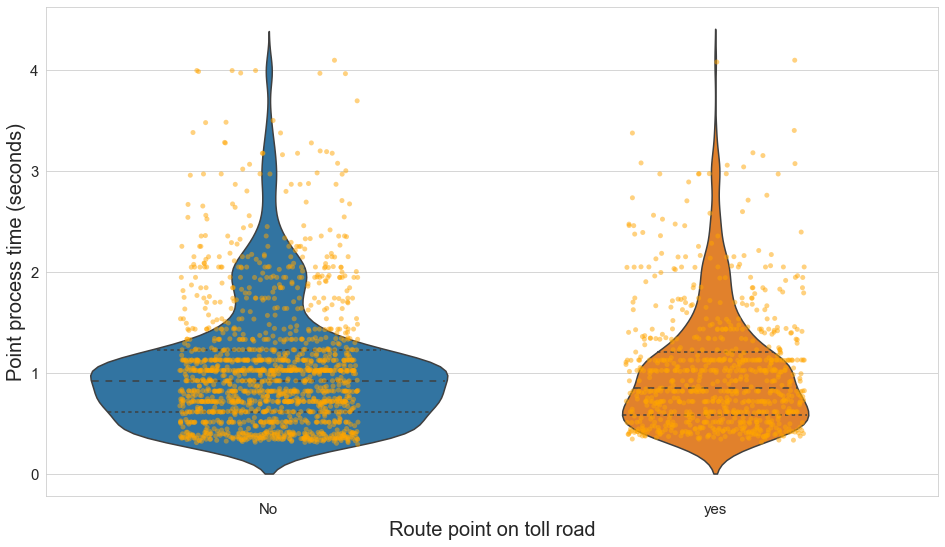

In [23]:
print('\nViolin plots with distribution of execution times for each category of' 
      ' route points \n(point is on toll road / point is not on toll road)')
print('\nOrange dots show individual elements ' 
      'and their distribution on the violin.')
plt.figure(figsize=(16, 9))
sns.set_style('whitegrid')

plot = sns.violinplot(x="toll", y="duration", data=stat_info_copy, 
                     scale='count', inner='quartile')
sns.stripplot(x="toll", y="duration", data=stat_info_copy, jitter=0.2,
              color='orange', alpha=0.5)
plot.set_xlabel("Route point on toll road",fontsize=20)
plot.set_ylabel("Point process time (seconds)",fontsize=20)
plot.tick_params(labelsize=15)